# Data visualization
This notebook is for visualizing the data distribution across different demographic groups to get a quick understanding of the sample population and any potential imbalances. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plot_likert
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from scripts import utils

In [3]:
# Vars
courses_cg = ["COMP202", "COMP250"]
courses_ee = ["COMP251", "COMP424", "COMP551"]
courses = courses_cg + courses_ee


deg_type = ["Undergraduate", "Graduate"]
years = ["U0", "U1", "U2", "U3", "U4+", "M1", "M2", "M3+", "PhD1", "PhD2", "PhD3", "PhD4", "PhD5+"]
majors = ["CS/SWE major", "CS/SWE minor", "Other"]
genders = ["Man", "Woman", "Other", "Prefer not to answer"]
minorities = ["Yes", "No", "Prefer not to answer"]
age = ["<18", "18-24", "25-34", "35-44", ">45", "Prefer not to answer"]
ethics_knowledge = ["Yes", "No"]
likert = range(1, 8)
likert_values = ["Strongly Disagree", "Disagree", "Somewhat Disagree", "Neutral", "Somewhat Agree", "Agree", "Strongly Agree"]

# current semester (for script purposes)
semester = "F2025"

In [4]:
data_dir = os.path.join(project_root, 'data')

ee_file = "F2025_ee_clean.csv"
cg_file = "F2025_cg_clean.csv"

ee_data_path = os.path.join(data_dir, 'clean', ee_file)
cg_data_path = os.path.join(data_dir, 'clean', cg_file)

In [5]:
ee_data = pd.read_csv(ee_data_path, header=[0,1], index_col=0)
cg_data = pd.read_csv(cg_data_path, header=[0,1], index_col=0)
data_all = [ee_data, cg_data]

# rebuild the multiindexing properly to make data access easier
for d in data_all:
    utils.rebuild_multiindex(d)

In [6]:
# number of total responses
n_ee = len(ee_data)
n_cg = len(cg_data)

print(f"Number of responses for EE: {n_ee}")
print(f"Number of responses for CG: {n_cg}")

Number of responses for EE: 52
Number of responses for CG: 59


Data per course - note that the "None" category is for students who are part of EE course but did not attend the lecture. 

In [7]:
course_data = {}
for course in courses:
    if course in courses_ee:
        course_data[course] = ee_data[ee_data["EE course"][course] == 1]

        # TODO: test this
        if course in cg_data["EE course"].columns:
            course_data[course] = pd.concat([course_data[course], cg_data[cg_data["EE course"][course] == 1]])
    else:
        course_data[course] = cg_data[cg_data["CG course"][course] == 1]
        
course_data["None"] = ee_data[ee_data["EE course"]["None"] == 1]

In [8]:
# number of total responses per course
n_courses = {}
for course in course_data:
    n_courses[course] = len(course_data[course])

for course in course_data:
    print(f"Number of responses for {course}: {n_courses[course]}")

Number of responses for COMP202: 33
Number of responses for COMP250: 26
Number of responses for COMP251: 11
Number of responses for COMP424: 20
Number of responses for COMP551: 19
Number of responses for None: 4


In [9]:
df_dict_n_courses = {"course": [],
                     "count": []}
for course in n_courses:
    df_dict_n_courses["course"].append(course)
    df_dict_n_courses["count"].append(n_courses[course])

n_courses_df = pd.DataFrame(df_dict_n_courses)

In [10]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%({v:d})'.format(pct, v=val)
        return my_format

Text(0.5, 1.0, 'Number of responses per course')

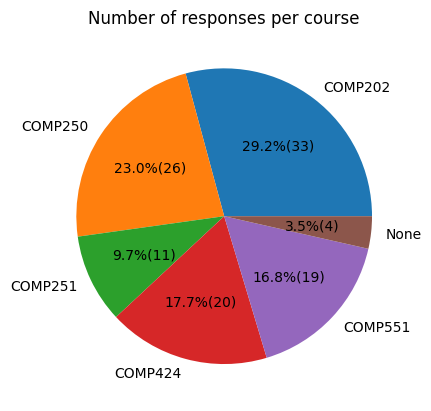

In [11]:
plt.pie(n_courses_df["count"], labels=n_courses_df["course"], autopct=autopct_format(n_courses_df["count"]))
plt.title("Number of responses per course")

## Degree
### EE vs CG

In [12]:
counts_deg_ee = ee_data["Degree type"].value_counts().reindex(deg_type, fill_value=0) # reindexing adds the categories with 0 count
counts_deg_cg = cg_data["Degree type"].value_counts().reindex(deg_type, fill_value=0)

In [13]:
print(f"EE course {counts_deg_ee}")
print("-------------")
print(f"CG course {counts_deg_cg}")

EE course Degree type
Undergraduate    48
Graduate          4
Name: count, dtype: int64
-------------
CG course Degree type
Undergraduate    59
Graduate          0
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

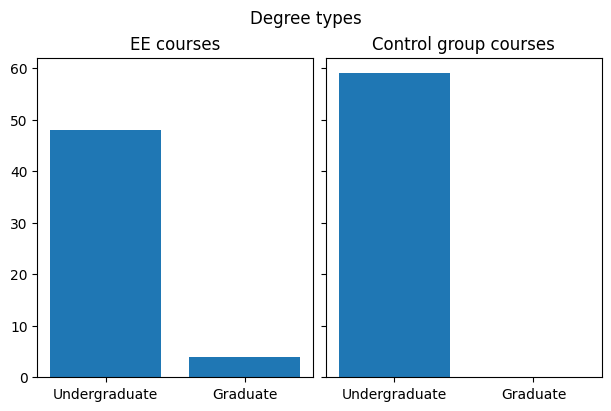

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.bar(deg_type, counts_deg_ee.values)
ax2.bar(deg_type, counts_deg_cg.values)

fig.suptitle("Degree types")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

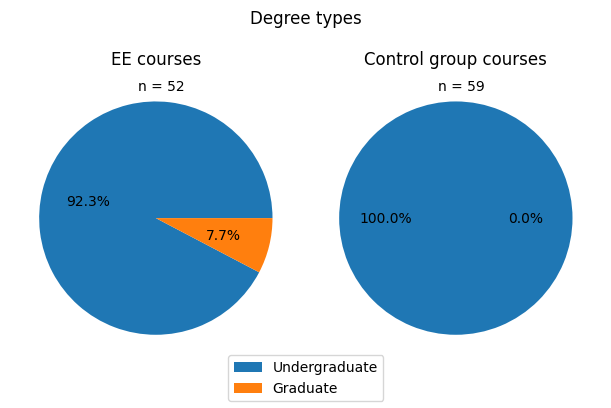

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_deg_ee.values, autopct='%.1f%%')
ax2.pie(counts_deg_cg.values, autopct='%.1f%%')

fig.suptitle("Degree types")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.15, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(deg_type, loc='lower center')

### Degree type per course

In [16]:
counts_deg_courses = {}
for course in course_data:
    counts_deg_courses[course] = course_data[course]["Degree type"].value_counts().reindex(deg_type, fill_value=0)

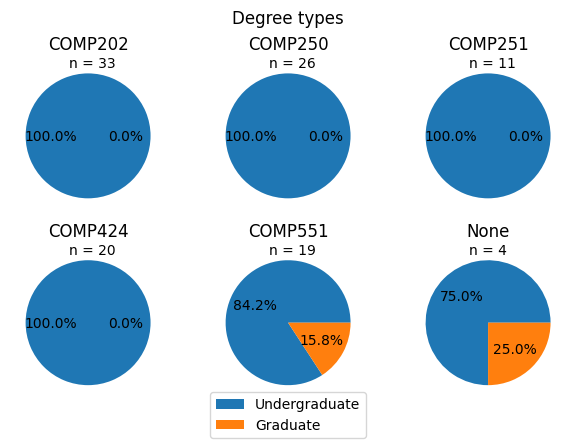

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_deg_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Degree types")
fig.legend(deg_type, loc='lower center', bbox_to_anchor=(0.5, -0.1))

## Year

#### EE vs CG

In [18]:
counts_year_ee = ee_data["Year"].value_counts().reindex(years, fill_value=0) # reindexing adds the categories with 0 count
counts_year_cg = cg_data["Year"].value_counts().reindex(years, fill_value=0)

In [19]:
print(f"EE course {counts_year_ee}")
print("-------------")
print(f"CG course {counts_year_cg}")

EE course Year
U0        0
U1        1
U2       12
U3       23
U4+      12
M1        2
M2        0
M3+       0
PhD1      0
PhD2      0
PhD3      1
PhD4      0
PhD5+     1
Name: count, dtype: int64
-------------
CG course Year
U0        9
U1       39
U2        7
U3        4
U4+       0
M1        0
M2        0
M3+       0
PhD1      0
PhD2      0
PhD3      0
PhD4      0
PhD5+     0
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

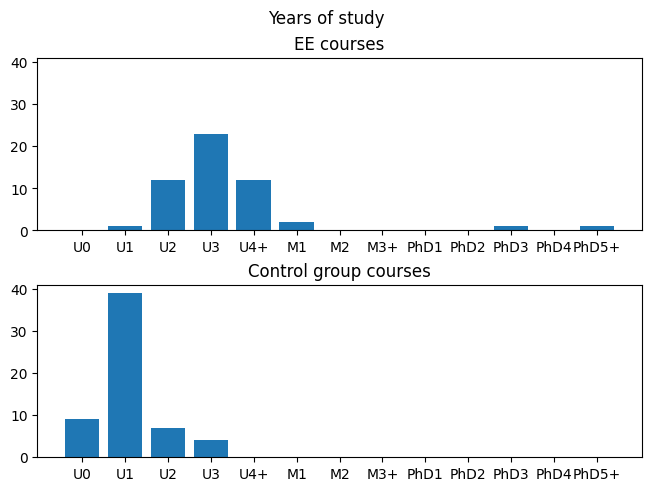

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.bar(years, counts_year_ee.values)
ax2.bar(years, counts_year_cg.values)

fig.suptitle("Years of study")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

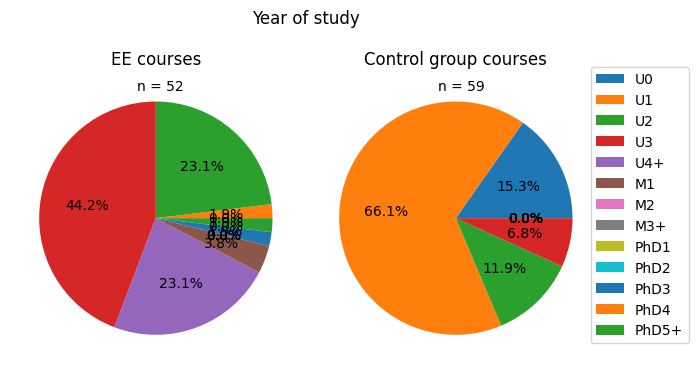

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_year_ee.values, autopct='%.1f%%')
ax2.pie(counts_year_cg.values, autopct='%.1f%%')

fig.suptitle("Year of study")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(years, loc='center right', bbox_to_anchor=(1.15, 0.5))

### Year per course

In [22]:
counts_year_courses = {}
for course in course_data:
    counts_year_courses[course] = course_data[course]["Year"].value_counts().reindex(years, fill_value=0)

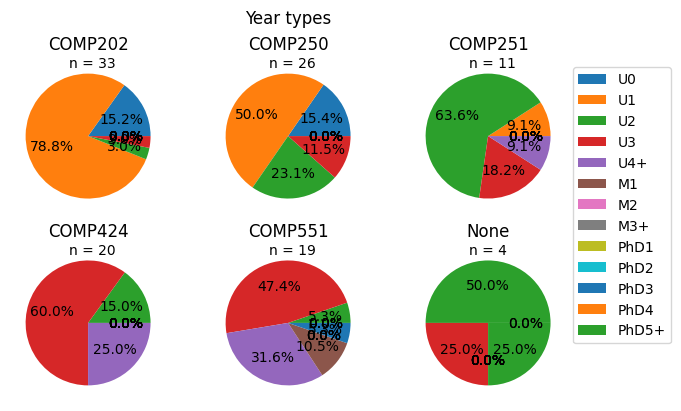

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_year_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Year types")
fig.legend(years, loc='center right', bbox_to_anchor=(1.15, 0.5))

## Major
#### EE vs CG

In [24]:
counts_major_ee_dict = {"Field": ["CS/SWE major", "CS/SWE minor", "Other"], 
                        "count": [ee_data["Field"]["CS/SWE major"].sum(), ee_data["Field"]["CS/SWE minor"].sum(), ee_data["Field"]["Other"].sum()]}
                        
counts_major_cg_dict = {"Field": ["CS/SWE major", "CS/SWE minor", "Other"], 
                        "count": [cg_data["Field"]["CS/SWE major"].sum(), cg_data["Field"]["CS/SWE minor"].sum(), cg_data["Field"]["Other"].sum()]}

counts_major_ee = pd.DataFrame(data=counts_major_ee_dict)
counts_major_cg = pd.DataFrame(data=counts_major_cg_dict)

In [25]:
print(f"EE course \n{counts_major_ee}")
print("-------------")
print(f"CG course \n{counts_major_cg}")

EE course 
          Field  count
0  CS/SWE major     39
1  CS/SWE minor      4
2         Other     13
-------------
CG course 
          Field  count
0  CS/SWE major     20
1  CS/SWE minor      9
2         Other     32


Text(0.5, 1.0, 'Control group courses')

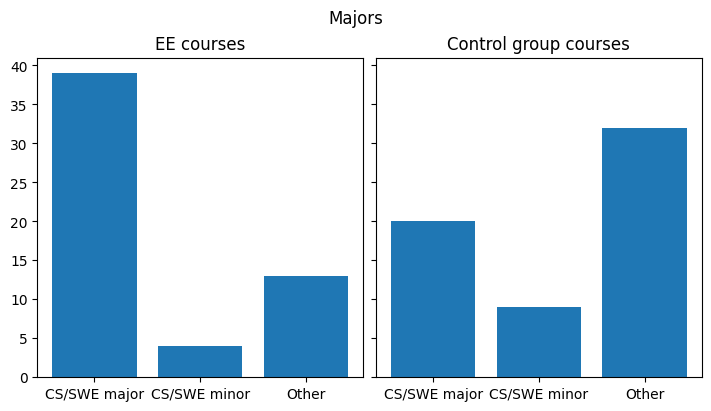

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(7, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.bar(majors, counts_major_ee["count"])
ax2.bar(majors, counts_major_cg["count"])

fig.suptitle("Majors")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

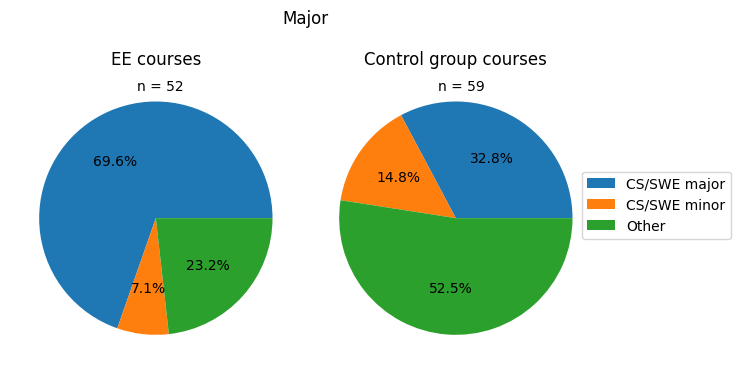

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_major_ee["count"], autopct='%.1f%%')
ax2.pie(counts_major_cg["count"], autopct='%.1f%%')

fig.suptitle("Major")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(majors, loc='center right', bbox_to_anchor=(1.22, 0.5))

### Major per course

In [27]:
counts_major_course = {}
for course in course_data:

    counts_major_dict = {"Field": ["CS/SWE major", "CS/SWE minor", "Other"], 
                        "count": [course_data[course]["Field"]["CS/SWE major"].sum(), course_data[course]["Field"]["CS/SWE minor"].sum(), course_data[course]["Field"]["Other"].sum()]}
                            

    counts_major_course[course] = pd.DataFrame(data=counts_major_dict)

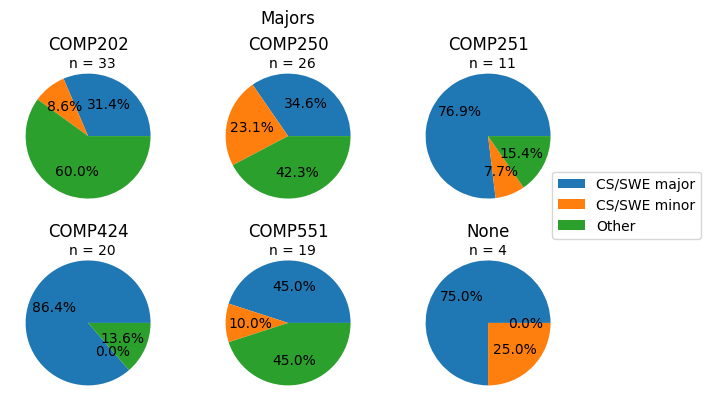

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_major_course[course]["count"], autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Majors")
fig.legend(majors, loc='center right', bbox_to_anchor=(1.2, 0.5))

## Gender
#### EE vs CG

In [176]:
counts_gender_ee = ee_data["Gender"].value_counts().reindex(genders, fill_value=0)
counts_gender_cg = cg_data["Gender"].value_counts().reindex(genders, fill_value=0)

In [177]:
print(f"EE course {counts_gender_ee}")
print("-------------")
print(f"CG course {counts_gender_cg}")

EE course Gender
Man                     28
Woman                   23
Other                    0
Prefer not to answer     1
Name: count, dtype: int64
-------------
CG course Gender
Man                     18
Woman                   38
Other                    0
Prefer not to answer     3
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

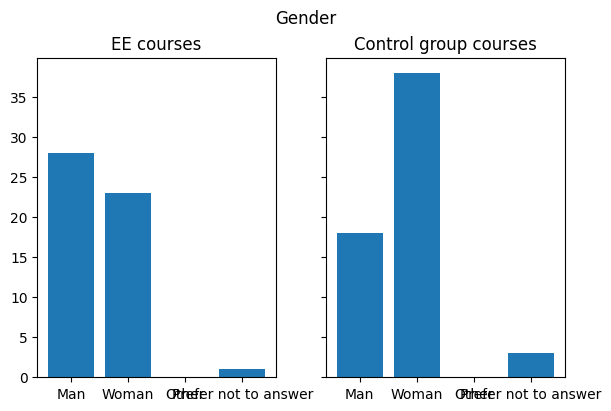

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.bar(genders, counts_gender_ee.values)
ax2.bar(genders, counts_gender_cg.values)

fig.suptitle("Gender")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

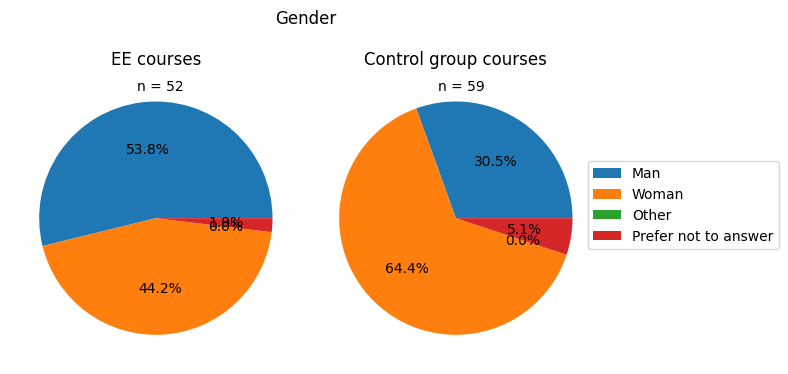

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_gender_ee.values, autopct='%.1f%%')
ax2.pie(counts_gender_cg.values, autopct='%.1f%%')

fig.suptitle("Gender")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(genders, loc='center right', bbox_to_anchor=(1.30, 0.5))

### Gender per course

In [29]:
counts_gender_courses = {}
for course in course_data:
    counts_gender_courses[course] = course_data[course]["Gender"].value_counts().reindex(genders, fill_value=0)

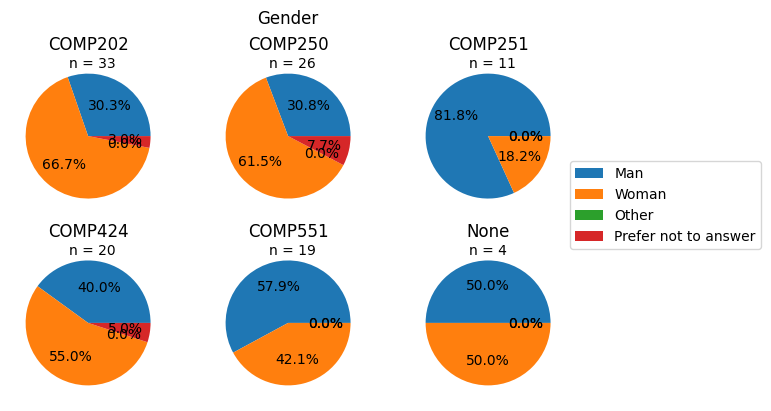

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_gender_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Gender")
fig.legend(genders, loc='center right', bbox_to_anchor=(1.3, 0.5))

## Visible minority
#### EE vs CG

In [180]:
counts_minority_ee = ee_data["Visible minority"].value_counts().reindex(minorities, fill_value=0)
counts_minority_cg = cg_data["Visible minority"].value_counts().reindex(minorities, fill_value=0)

In [181]:
print(f"EE course {counts_minority_ee}")
print("-------------")
print(f"CG course {counts_minority_cg}")

EE course Visible minority
Yes                     30
No                      21
Prefer not to answer     1
Name: count, dtype: int64
-------------
CG course Visible minority
Yes                     26
No                      29
Prefer not to answer     4
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

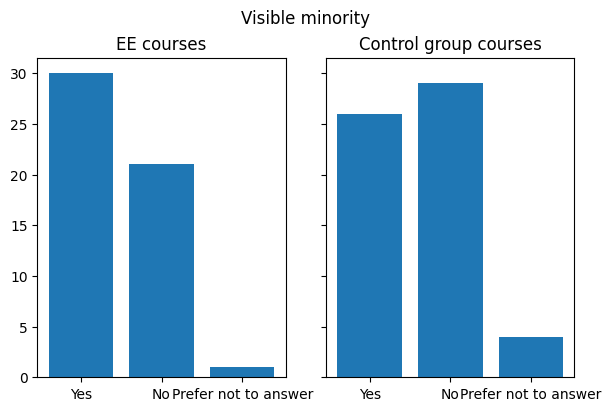

In [182]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.bar(minorities, counts_minority_ee.values)
ax2.bar(minorities, counts_minority_cg.values)

fig.suptitle("Visible minority")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

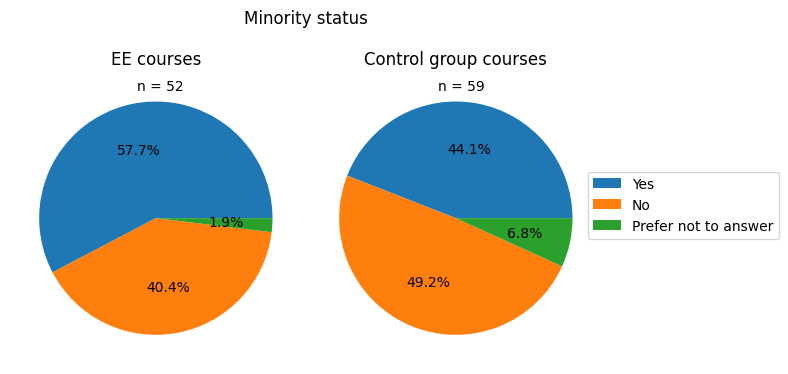

In [183]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_minority_ee.values, autopct='%.1f%%')
ax2.pie(counts_minority_cg.values, autopct='%.1f%%')

fig.suptitle("Minority status")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(minorities, loc='center right', bbox_to_anchor=(1.30, 0.5))

### Visible minority per course

In [35]:
counts_minority_courses = {}
for course in course_data:
    counts_minority_courses[course] = course_data[course]["Visible minority"].value_counts().reindex(minorities, fill_value=0)

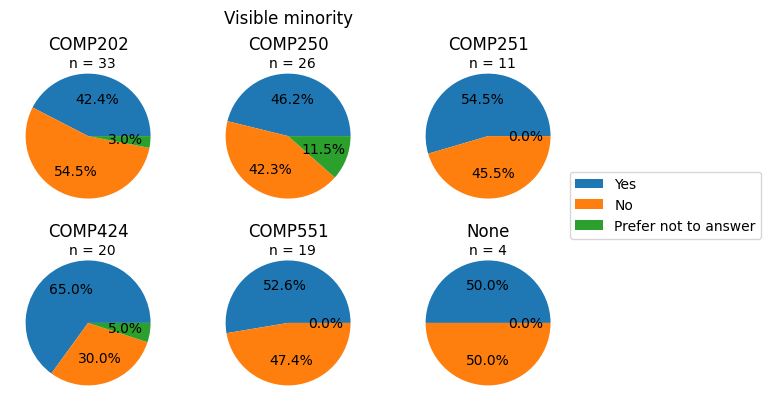

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_minority_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Visible minority")
fig.legend(minorities, loc='center right', bbox_to_anchor=(1.3, 0.5))

## Age
#### EE vs CG

In [184]:
counts_age_ee = ee_data["Age"].value_counts().reindex(age, fill_value=0)
counts_age_cg = cg_data["Age"].value_counts().reindex(age, fill_value=0)

In [185]:
print(f"EE course {counts_age_ee}")
print("-------------")
print(f"CG course {counts_age_cg}")

EE course Age
<18                      0
18-24                   49
25-34                    2
35-44                    0
>45                      0
Prefer not to answer     1
Name: count, dtype: int64
-------------
CG course Age
<18                      0
18-24                   59
25-34                    0
35-44                    0
>45                      0
Prefer not to answer     0
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

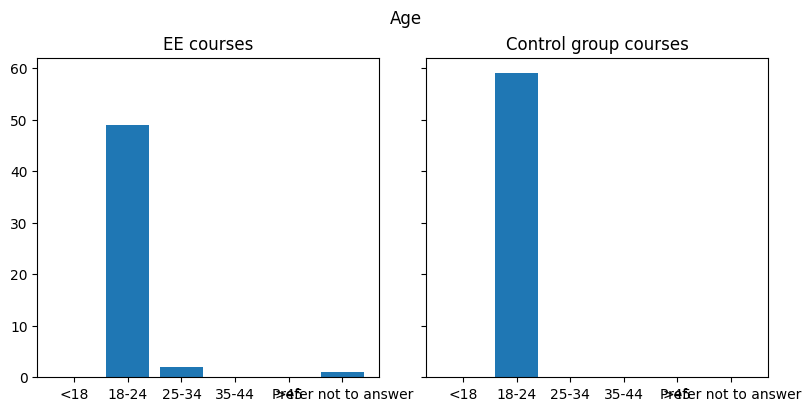

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.bar(age, counts_age_ee.values)
ax2.bar(age, counts_age_cg.values)

fig.suptitle("Age")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

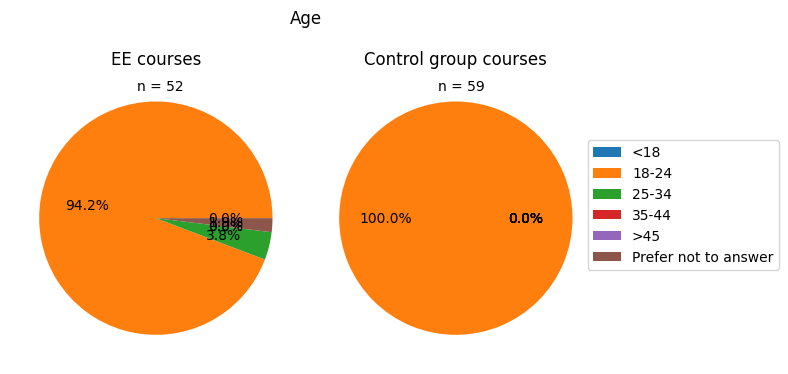

In [187]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_age_ee.values, autopct='%.1f%%')
ax2.pie(counts_age_cg.values, autopct='%.1f%%')

fig.suptitle("Age")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(age, loc='center right', bbox_to_anchor=(1.30, 0.5))

### Age per course


In [37]:
counts_age_courses = {}
for course in course_data:
    counts_age_courses[course] = course_data[course]["Age"].value_counts().reindex(age, fill_value=0)

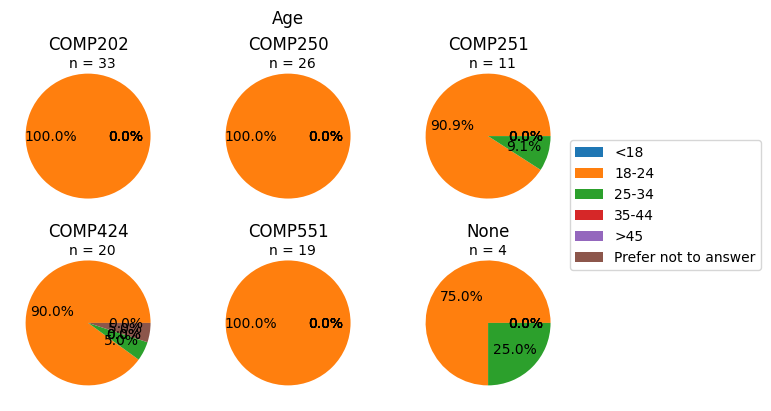

In [39]:

fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_age_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Age")
fig.legend(age, loc='center right', bbox_to_anchor=(1.3, 0.5))

## Ethics experience
### EE vs CG

In [188]:
counts_ethics_ee = ee_data["Ethics experience"].value_counts().reindex(ethics_knowledge, fill_value=0)
counts_ethics_cg = cg_data["Ethics experience"].value_counts().reindex(ethics_knowledge, fill_value=0)

In [189]:
print(f"EE course {counts_ethics_ee}")
print("-------------")
print(f"CG course {counts_ethics_cg}")

EE course Ethics experience
Yes    23
No     29
Name: count, dtype: int64
-------------
CG course Ethics experience
Yes    23
No     36
Name: count, dtype: int64


Text(0.5, 1.0, 'Control group courses')

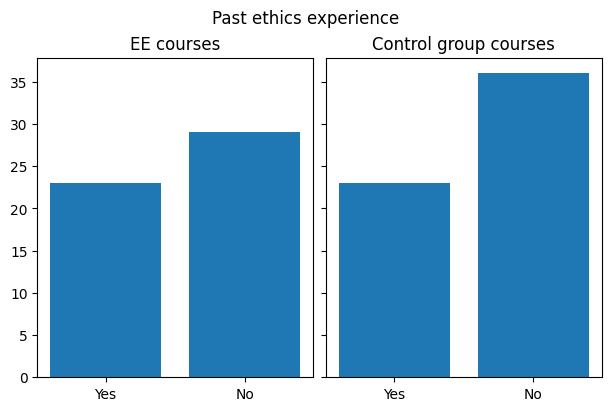

In [190]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.bar(ethics_knowledge, counts_ethics_ee.values)
ax2.bar(ethics_knowledge, counts_ethics_cg.values)

fig.suptitle("Past ethics experience")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

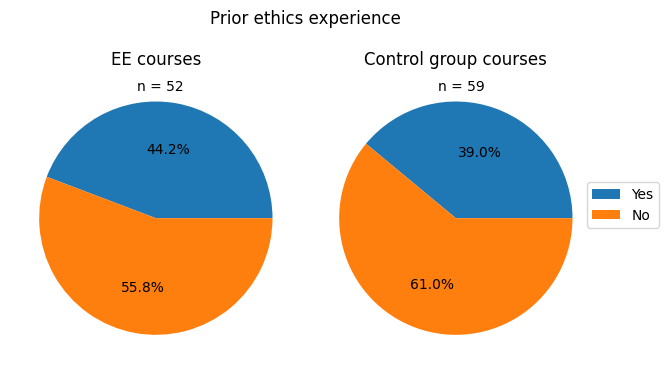

In [193]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

ax1.pie(counts_ethics_ee.values, autopct='%.1f%%')
ax2.pie(counts_ethics_cg.values, autopct='%.1f%%')

fig.suptitle("Prior ethics experience")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")
ax1.annotate(f"n = {n_ee}", xy=(-0.16, 1.1))
ax2.annotate(f"n = {n_cg}", xy=(-0.15, 1.1))
fig.legend(ethics_knowledge, loc='center right', bbox_to_anchor=(1.1, 0.5))

### Prior ethics experience per course

In [43]:
counts_ethics_courses = {}
for course in course_data:
    counts_ethics_courses[course] = course_data[course]["Ethics experience"].value_counts().reindex(ethics_knowledge, fill_value=0)

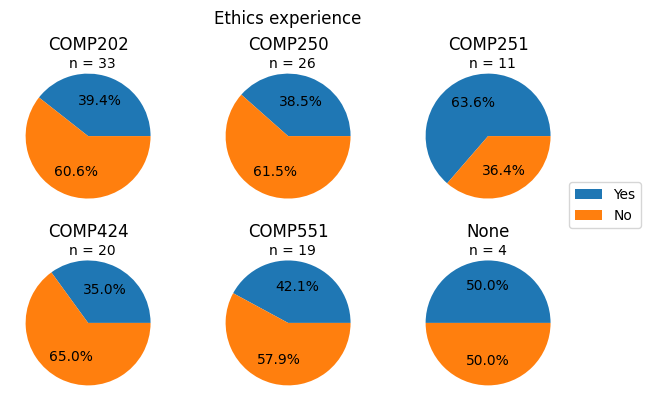

In [46]:

fig, axes = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    row, col = i//3, i%3
    axes[row, col].pie(counts_ethics_courses[course].values, autopct='%.1f%%')
    axes[row, col].set_title(course)
    axes[row, col].annotate(f"n = {n_courses[course]}", xy=(-0.3, 1.1))

fig.suptitle("Ethics experience")
fig.legend(ethics_knowledge, loc='center right', bbox_to_anchor=(1.1, 0.5))

## Career questions
### EE vs CG

c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)


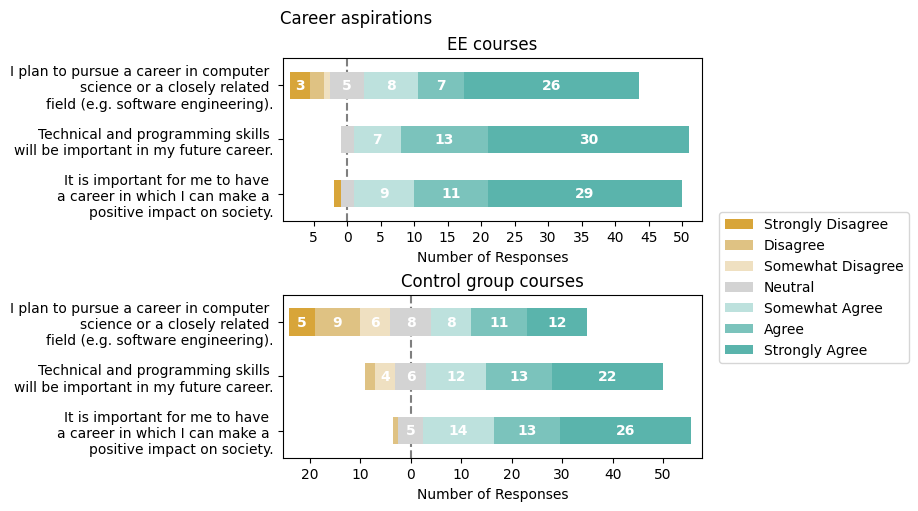

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), constrained_layout=True, sharey=True) # draw two plots in one row, two columns

plot_likert.plot_likert(ee_data["Career"], likert, colors=plot_likert.colors.likert7, bar_labels=True, ax=ax1, legend=False)
plot_likert.plot_likert(cg_data["Career"], likert,colors=plot_likert.colors.likert7, bar_labels=True, ax=ax2, legend=False)

fig.suptitle("Career aspirations")
ax1.set_title("EE courses")
ax2.set_title("Control group courses")

ax1.set_yticklabels(["I plan to pursue a career in computer \nscience or a closely related \nfield (e.g. software engineering).",
                     "Technical and programming skills \nwill be important in my future career.",
                     "It is important for me to have \na career in which I can make a \npositive impact on society."][::-1])
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, likert_values, bbox_to_anchor=(1.3, 0.6))

### Career questions per course

c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\analysis-embedded-ethics\venv\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Etomiuk\OneDrive\OneNote\EE_data_analysis\a

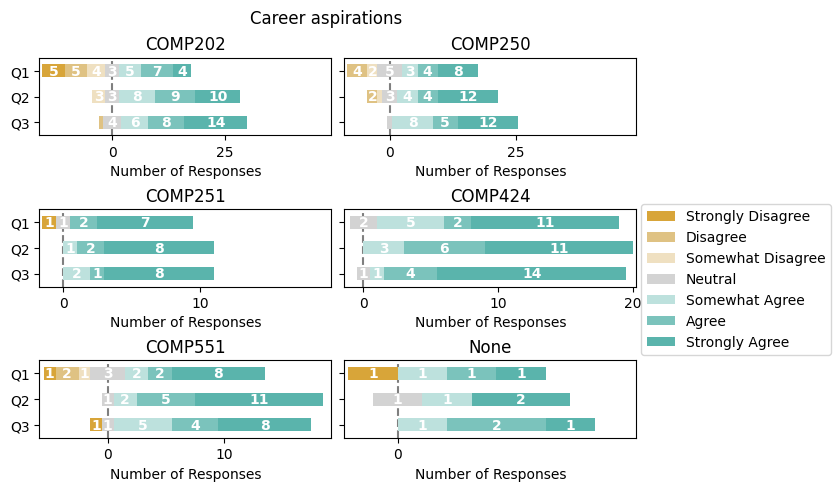

In [ ]:
fig, axes = plt.subplots(3, 2, constrained_layout=True, sharey=True) # draw two plots in one row, two columns

for i, course in enumerate(course_data):
    #print(course_data[course]["Career"])
    row, col = i//2, i%2
    plot_likert.plot_likert(course_data[course]["Career"], likert, colors=plot_likert.colors.likert7, ax=axes[row, col], bar_labels=True, legend=False)
    axes[row, col].set_title(course)    

fig.suptitle("Career aspirations")
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, likert_values, bbox_to_anchor=(1.3, 0.6))